[View in Colaboratory](https://colab.research.google.com/github/jpskycak/research_notebooks/blob/master/programmable_self_assembly_into_non_simply_connected_shapes.ipynb)

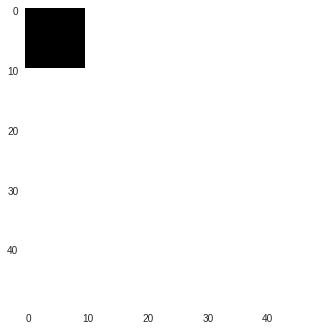

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import uuid

# initial coordinates for agents
L = 10
gridshape = (5*L,5*L)
grid = np.zeros(gridshape)
grid[:L,:L] = 1
plt.imshow(grid)
plt.grid(False)
plt.show()

In [14]:
# instantiate agents at initial coordinates

agents = [{'true_coordinates':(x,y),'id':str(uuid.uuid4())} for x in range(gridshape[0]) for y in range(gridshape[1]) if grid[x,y]==1]

def in_radius(test_point,center,radius):
  out = False
  if abs(test_point[0]-center[0])<= radius:
    if abs(test_point[1]-center[1])<= radius:
      out = True
  return out

def get_neighbors(agent,radius=3):
  center = agent['true_coordinates']
  neighbors = [i for i,a in enumerate(agents) if in_radius(a['true_coordinates'],center,radius) and a['id'] != agent['id']]
  return neighbors

for a in agents:
  a['neighbors'] = get_neighbors(a)
  
agents[0]

{'id': 'c929b0c9-e6f1-40b5-b40d-821887abec45',
 'neighbors': [1, 2, 3, 10, 11, 12, 13, 20, 21, 22, 23, 30, 31, 32, 33],
 'true_coordinates': (0, 0)}

In [21]:
# initialize gradient values. source agent is at (L-1,L-1)

for a in agents:
  if a['true_coordinates'] == (L-1,L-1):
    a['gradient_value'] = 0
    for neighbor_index in a['neighbors']:
      neighbor = agents[neighbor_index]
      neighbor['gradient_value'] = 1
      
def do_all_agents_have_gradient_values():
  ans = True
  for a in agents:
    if 'gradient_value' not in a.keys():
      ans = False
  return ans

while not do_all_agents_have_gradient_values():
  for a in agents:
    if 'gradient_value' not in a.keys():
      neighbors = [agents[i] for i in a['neighbors']]
      min_gradient_in_neighbors = 9*10**10
      should_assign_gradient_value = False
      for neighbor in neighbors:
        if 'gradient_value' in neighbor.keys():
          min_gradient_in_neighbors = min(neighbor['gradient_value'],min_gradient_in_neighbors)
          should_assign_gradient_value = True
      if should_assign_gradient_value:
        a['gradient_value'] = 1+min_gradient_in_neighbors
  
agents[0]

{'gradient_value': 3,
 'id': 'c929b0c9-e6f1-40b5-b40d-821887abec45',
 'neighbors': [1, 2, 3, 10, 11, 12, 13, 20, 21, 22, 23, 30, 31, 32, 33],
 'true_coordinates': (0, 0)}

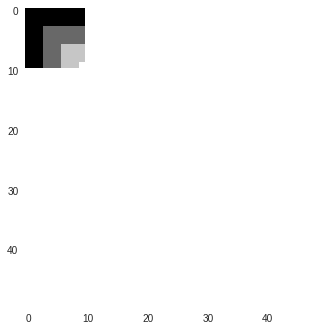

In [25]:
# check gradient
gradient = np.zeros(gridshape)
for a in agents:
  [x,y] = a['true_coordinates']
  gradient[x,y] = a['gradient_value']
  
plt.imshow(gradient)
plt.grid(False)
plt.show()

In [0]:
# initialize estimated_coordinates


In [0]:
def euclidean_distance(x0,x1):
  return sum((np.array(x0)-np.array(x1))**2)**.5

NameError: ignored

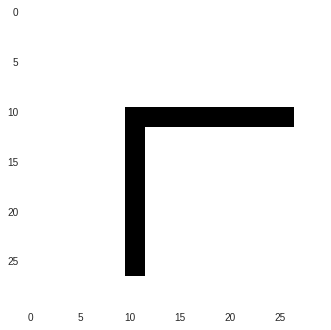

In [31]:
shape = np.zeros(gridshape)
shape[L:-3,L:-3] = 1
shape[int(1.25*L):-3,int(1.25*L):-3] = 0
plt.imshow(shape)
plt.grid(False)
plt.show()